# Title
Regression Project (Store Sales -- Time Series Forecasting)

# Project Description
In this project, we will predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer. This is a time series forecasting problem.

Specifically, we are to build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

# Hypothesis
## Null Hypothesis, HO
Series is non-stationary
## AlternativeHypothesis, H1
Series is stationary
# Questions
1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

ADDITIONAL QUESTIONS

8. What is the trend of sales over time?
9. What is the trend of transactions over time?
10. Highest and lowest performing stores in terms of sales
11. Highest performing family of products


# Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
from pandas_profiling import ProfileReport
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
holidays=pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
oil=pd.read_csv("store-sales-time-series-forecasting/oil.csv")
sample=pd.read_csv("store-sales-time-series-forecasting/sample_submission.csv")
stores=pd.read_csv("store-sales-time-series-forecasting/stores.csv")
test=pd.read_csv("store-sales-time-series-forecasting/test.csv")
train=pd.read_csv("store-sales-time-series-forecasting/train.csv", parse_dates =['date'])
transactions=pd.read_csv("store-sales-time-series-forecasting/transactions.csv")

# Exploratory Data Analysis: EDA
# Dataset overview

In [3]:
# profile_data = ProfileReport(train, title ="train Profiling Report")
# profile_data

Our date starts from January 2013 till October 2017 in our train data

Also in our train dataset, Sales has a strong positive correlation with onpromotion, so we'll focus on sales and onpromotion

since they correlate with one another the most

No missing values in both our train and test data

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


we can see that the date column is in object instead of datetime

so we will convert the datatypes

# Data Preparation and Processing

converting date columns to datetime

In [6]:
#converting date columns to datetime
def to_dateTime(df):
    df['date'] = pd.to_datetime(df['date'])

to_dateTime(transactions)
to_dateTime(test)
to_dateTime(oil)
to_dateTime(holidays)

### check for missing dates

In [7]:
missing_transaction_dates = (pd.date_range(
    start=transactions.date.min(),
    end=transactions.date.max())
    .difference(transactions.date)
)
missing_transaction_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-01-01',
               '2016-01-03', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)

transactions has missing dates, so we first check the transactions data to see how best to fill them

In [8]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


each date in transactions is iterated with each store_nbr, so we'll use itertools.product() function

transactions on missing dates will be zero

In [9]:
from itertools import product
missing_transactions = list(product(missing_transaction_dates, transactions.store_nbr.unique()))
transactions_extra = pd.DataFrame(missing_transactions, columns=['date', 'store_nbr'])

merge transactions with missing ones and fill missing transactions with 0

In [10]:
transactions = pd.concat([transactions, transactions_extra], ignore_index=True)
transactions.transactions.fillna(0, inplace=True)

## 1. Is the train dataset complete (has all the required dates)?

From the information below you can see the train dataset has missing dates

In [11]:
missing_train_dates = (pd.date_range(
    start=train.date.min(),
    end=train.date.max())
    .difference(train.date)
)
missing_train_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [12]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


each date iterates across each unique store_nbr

each store_nbr also iterates across every family, so we use itertools.product() function again

In [13]:
from itertools import product
missing_train = list(product(missing_train_dates, train.store_nbr.unique(), train.family.unique()))
train_extra = pd.DataFrame(missing_train, columns=['date', 'store_nbr', 'family'])

In [14]:
# adding missing dates to train
train = pd.concat([train, train_extra], ignore_index=True)
# fill missing sales and onpromotion with zero, just like with train
train.sales.fillna(0, inplace=True)
train.onpromotion.fillna(0, inplace=True)

In [15]:
missing_test_dates = (pd.date_range(
    start=test.date.min(),
    end=test.date.max())
    .difference(test.date)
)
missing_test_dates

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

test data has no missing dates

In [16]:
missing_oil_dates = (pd.DataFrame(
    pd.date_range(
    start=oil.date.min(),
    end=oil.date.max())
    .difference(oil.date)
, columns=['date']))

missing_oil_dates

,date
0,2013-01-05
1,2013-01-06
2,2013-01-12
3,2013-01-13
4,2013-01-19
...,...
481,2017-08-13
482,2017-08-19
483,2017-08-20
484,2017-08-26


In [17]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


for our oil data, we'll first fill missing dates, then we'll interpplate and bfill to fix missing oil prices

In [18]:
#add missing oil dates
oil = pd.concat([oil, missing_oil_dates], ignore_index=True)

#filling missing oil values
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear').ffill().bfill()

In [19]:
missing_holiday_dates = (pd.DataFrame(
    pd.date_range(
    start=holidays.date.min(),
    end=holidays.date.max())
    .difference(holidays.date)
, columns=['date']))

missing_holiday_dates

,date
0,2012-03-03
1,2012-03-04
2,2012-03-05
3,2012-03-06
4,2012-03-07
...,...
1809,2017-12-16
1810,2017-12-17
1811,2017-12-18
1812,2017-12-19


In [20]:
holidays = pd.concat([holidays, missing_holiday_dates], ignore_index=True)

In [21]:
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

the family column has too many categories. This could complicate our machine learning model later on

so we'll group them into smaller categories later

In [22]:
holidays.tail(),holidays.shape

(           date type locale locale_name description transferred
 2159 2017-12-16  NaN    NaN         NaN         NaN         NaN
 2160 2017-12-17  NaN    NaN         NaN         NaN         NaN
 2161 2017-12-18  NaN    NaN         NaN         NaN         NaN
 2162 2017-12-19  NaN    NaN         NaN         NaN         NaN
 2163 2017-12-20  NaN    NaN         NaN         NaN         NaN,
 (2164, 6))

if the holiday was transferred, then its no longer an holiday

so we'll delete the rows with transferred as true

In [23]:
# delete rows with transferred as true
transferred_true = holidays[ (holidays['transferred'] == True)].index
holidays.drop(transferred_true , inplace=True)

In [24]:
#drop unnecessary columns in holidays
holidays.drop(
    columns=['locale', 'locale_name', 'description', 'transferred'],
    inplace=True
    )

In [25]:
#the id column doesn't give additional info, so we drop it
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [26]:
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [27]:
# renaming our dcoilwtico column in oil data
oil.rename(
    columns = {'dcoilwtico':'oil_price'}, 
    inplace = True
    )

In [28]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [29]:

mer = train.merge(
    stores, 
    how='left', 
    on=['store_nbr'])

merged=mer.merge(
    transactions, 
    how='left', 
    on=['date', 'store_nbr'])

In [30]:
#merging merged with oil data
merged2=mer.merge(
    oil,
    how='left', 
    on=['date'])


merged2.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,oil_price
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,93.14
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,93.14
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,93.14
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,93.14
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,93.14


In [31]:
#merging merged2 with holidays
merged3=merged2.merge(holidays,
    how='left', 
    on=['date'])

print(merged3.shape)
merged3.head()

(3061476, 11)


,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,oil_price,type_y
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday


## 6.What analysis can we get from the date and its extractable features?

In [32]:
def getDateFeatures(df):
    
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['week_of_year'] = df['week_of_year'].astype(float)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df["is_weekend"] = np.where(df['day_of_week'] > 4, 1, 0)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    df['pay_day'] = np.where((df['day_of_month']==15) | (df['is_month_end']==1), 1, 0)
    df['earthquake_impact'] = np.where(df['date'].isin(
        pd.date_range(start='2016-04-16', end='2016-12-31', freq='D')), 1, 0)

    return df

In [33]:
merged3.isnull().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
oil_price            0
type_y         2567862
dtype: int64

since non-holidays are work days, let's impute the last column

In [34]:
merged3['type_y'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [35]:
work_days = merged3[merged3['type_y'] == 'Work Day']
print(work_days.nunique())
work_days

date              5
store_nbr        54
family           33
sales          2524
onpromotion      91
city             22
state            16
type_x            5
cluster          17
oil_price         1
type_y            1
dtype: int64


,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,oil_price,type_y
7128,2013-01-05,1,AUTOMOTIVE,5.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7129,2013-01-05,1,BABY CARE,0.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7130,2013-01-05,1,BEAUTY,3.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7131,2013-01-05,1,BEVERAGES,1160.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7132,2013-01-05,1,BOOKS,0.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
...,...,...,...,...,...,...,...,...,...,...,...
2555379,2016-11-12,9,POULTRY,529.684,1.0,Quito,Pichincha,B,6,47.26,Work Day
2555381,2016-11-12,9,PREPARED FOODS,158.774,2.0,Quito,Pichincha,B,6,47.26,Work Day
2555383,2016-11-12,9,PRODUCE,1618.001,2.0,Quito,Pichincha,B,6,47.26,Work Day
2555385,2016-11-12,9,SCHOOL AND OFFICE SUPPLIES,3.000,0.0,Quito,Pichincha,B,6,47.26,Work Day


In [36]:
# Fill missing holiday rows with work days
imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='Work Day')
merged3['type_y'] = imputer.fit_transform(merged3[['type_y']])

In [37]:
merged3.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type_x         0
cluster        0
oil_price      0
type_y         0
dtype: int64

## New Features Creation

In [38]:
merged3 = getDateFeatures(merged3)

let's make the date column the index

In [39]:
merged3=merged3.set_index(['date'])

## Features Encoding & scaling

In [40]:
merged3.head(2)

,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,oil_price,type_y,...,is_month_start,quarter,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,pay_day,earthquake_impact
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday,...,1,1,0,1,0,1,0,0,0,0
2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday,...,1,1,0,1,0,1,0,0,0,0


In [41]:
cols = ['family', 'city', 'state', 'cluster', 'type_y', 'type_x']
for col in cols:
  merged3[col] = LabelEncoder().fit_transform(merged3[col])

In [42]:
merged3_daily_mean = merged3.resample('D').mean()
print(merged3_daily_mean.shape)
merged3_daily_mean.head(3)

(1688, 27)


,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,oil_price,type_y,...,is_month_start,quarter,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,pay_day,earthquake_impact
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,27.5,16.0,1.409438,0.0,12.555556,8.796296,2.0,7.481481,93.14,3.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02,27.5,16.0,278.390807,0.0,12.555556,8.796296,2.0,7.481481,93.14,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,27.5,16.0,202.840197,0.0,12.555556,8.796296,2.0,7.481481,92.97,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
train1=merged3_daily_mean

In [44]:
trainn, evall = merged3[30000:], merged3[:30000]

In [45]:
# Split data into parts
x = trainn.drop(['sales'], axis = 1)
y = trainn['sales']

In [46]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[200:], x[:200], y[200:], y[:200]

# Machine Learning Modeling 

# Traditional Machine Learning Models

### Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
model_lin = lin_model.fit(X_train, y_train)

# Make prediction on X_test
lin_pred = model_lin.predict(X_test)

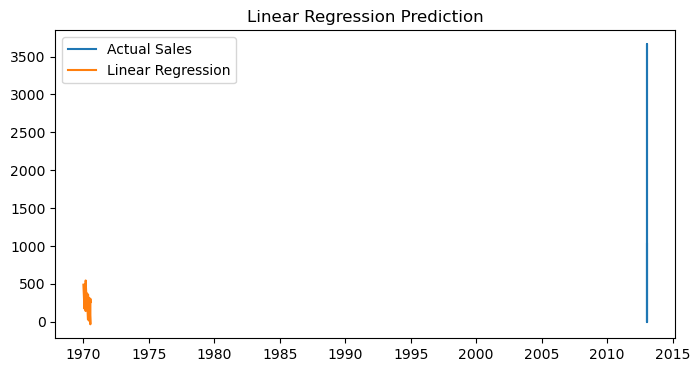

In [48]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(lin_pred, label='Linear Regression')
plt.legend(loc='best')
plt.title('Linear Regression Prediction')
plt.show()

In [49]:
mse = mean_squared_error(y_test, lin_pred )
rmse = np.sqrt(mean_squared_error(y_test, lin_pred )).round(2)

results = pd.DataFrame([['Linear', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
results

,Model,MSE,RMSE
0,Linear,230030.436642,479.61


## AR

In [50]:
x=train1['sales']
X_train, X_test = x[:1673], x[1673:]
print(len(X_train), len(X_test))
print(len(x), len(X_train)+len(X_test))

1673 15
1688 1688


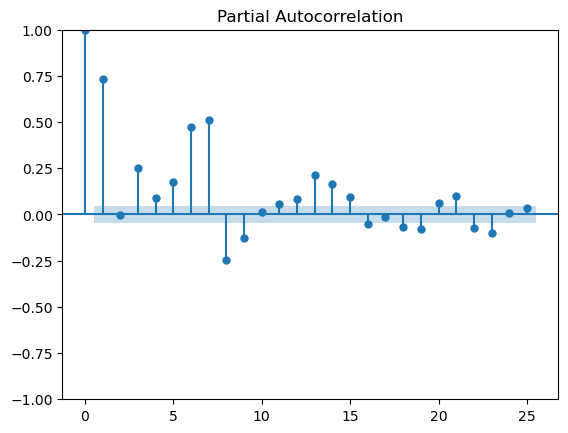

In [51]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(X_train,lags = 25)

In [52]:
from statsmodels.tsa.ar_model import AutoReg
armodel = AutoReg(X_train, lags = 9).fit()

In [53]:
pred = armodel.predict(
    start=len(X_train),
    end=len(x)-1,
    dynamic=False
)
pred

2017-08-01    430.265045
2017-08-02    427.312872
2017-08-03    401.198627
2017-08-04    462.388781
2017-08-05    555.825688
2017-08-06    579.965121
2017-08-07    484.206751
2017-08-08    426.489922
2017-08-09    422.410429
2017-08-10    410.512726
2017-08-11    454.029225
2017-08-12    528.444708
2017-08-13    540.988688
2017-08-14    469.514329
2017-08-15    422.532846
Freq: D, dtype: float64

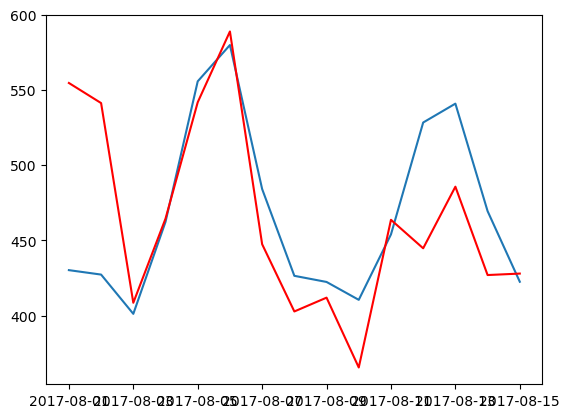

In [54]:
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(X_test, color='red')

In [55]:
mse = mean_squared_error(X_test, pred )
msle = mean_squared_log_error(X_test, pred)
rmse = np.sqrt(mean_squared_error(X_test, pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(X_test, pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,230030.436642,479.61,NaN,NaN
1,AR,2989.986841,54.68,0.013027,0.11414


## ARIMA

In [56]:
# We use pmdarima to determine the best parameter for our ARIMA model.
from pmdarima import auto_arima

In [57]:
stepwise_fit = auto_arima(X_train, trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19330.671, Time=2.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20037.705, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20012.898, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19724.002, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20035.721, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19390.563, Time=1.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19364.535, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19344.068, Time=2.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19033.451, Time=3.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19392.779, Time=1.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19189.193, Time=4.35 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=19232.069, Time=4.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=19348.289, Time=3.21 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=18989.843, Time=5.22 sec
 ARIMA(4,1,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1673
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -9318.666
Date:                Tue, 21 Feb 2023   AIC                          18659.331
Time:                        10:03:38   BIC                          18718.971
Sample:                    01-01-2013   HQIC                         18681.428
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5854      3.037      0.193      0.847      -5.367       6.537
ar.L1          0.3212      0.033      9.775      0.000       0.257       0.386
ar.L2         -1.0076      0.030    -33.449      0.000      -1.067      -0.949
ar.L3          0.0655      0.043      1.513      0.130      -0.019       0.150
ar.L4         -0.5736      0.021    -26.927      0.000      -0.615      -0.532
ar.L5         -0.4640      0.025    -18.484      0.000      -0.513      -0.415
ma.L1         -0.8350      0.029    -28.319      0.000      -0.893      -0.777
ma.L2          1.0996      0.039     27.935      0.000       1.022       1.177
ma.L3         -0.5281      0.036    -14.740      0.000      -0.598      -0.458
ma.L4          0.6017      0.021     28.376      0.000       0.560       0.643
sigma2      5133.9994     73.128     70.206      0.000    4990.671    5277.327
===================================================================================
Ljung-Box (L1) (Q):                   4.50   Jarque-Bera (JB):             57402.13
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               3.59   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
from statsmodels.tsa.arima.model import ARIMA

In [59]:
model = ARIMA(X_train, order=(5,1,4))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1673
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -9320.590
Date:                Tue, 21 Feb 2023   AIC                          18661.181
Time:                        10:03:42   BIC                          18715.398
Sample:                    01-01-2013   HQIC                         18681.269
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2773      0.032      8.565      0.000       0.214       0.341
ar.L2         -0.9737      0.030    -32.570      0.000      -1.032      -0.915
ar.L3          0.0104      0.043      0.240      0.810      -0.075       0.096
ar.L4         -0.5439      0.022    -25.156      0.000      -0.586      -0.502
ar.L5         -0.4978      0.025    -20.109      0.000      -0.546      -0.449
ma.L1         -0.8079      0.029    -27.566      0.000      -0.865      -0.750
ma.L2          1.0559      0.038     27.675      0.000       0.981       1.131
ma.L3         -0.5056      0.036    -14.076      0.000      -0.576      -0.435
ma.L4          0.5786      0.022     26.293      0.000       0.535       0.622
sigma2      5196.5801     73.243     70.950      0.000    5053.026    5340.134
===================================================================================
Ljung-Box (L1) (Q):                   2.83   Jarque-Bera (JB):             55701.75
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.55   Skew:                            -1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
# Make predictions on the test data
ARIMA_pred = model_fit.predict(
    start=len(X_train),
    end=len(x)-1,
    typ="levels")
ARIMA_pred

2017-08-01    451.011841
2017-08-02    437.698350
2017-08-03    422.790140
2017-08-04    469.047789
2017-08-05    587.789869
2017-08-06    605.714753
2017-08-07    510.284492
2017-08-08    449.865568
2017-08-09    438.603277
2017-08-10    424.451921
2017-08-11    473.846996
2017-08-12    581.578756
2017-08-13    599.415058
2017-08-14    513.280938
2017-08-15    453.328160
Freq: D, Name: predicted_mean, dtype: float64

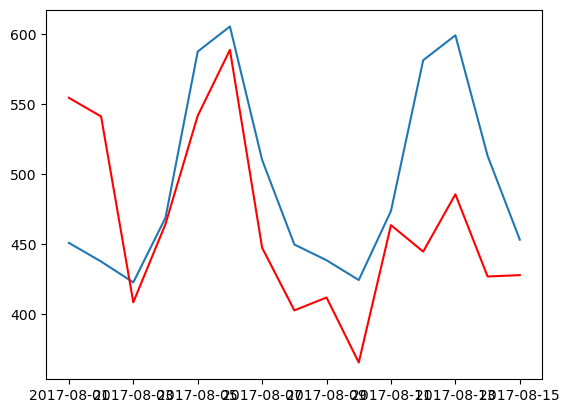

In [71]:
pyplot.plot(ARIMA_pred)
pyplot.plot(X_test, color='red')

In [61]:
# Evaluate our models
mse = mean_squared_error(X_test, ARIMA_pred)
msle = mean_squared_log_error(X_test, ARIMA_pred)
rmse = np.sqrt(mean_squared_error(X_test, ARIMA_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(X_test, ARIMA_pred)).round(2)

model_results = pd.DataFrame([['ARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,230030.436642,479.61,NaN,NaN
1,AR,2989.986841,54.68,0.013027,0.11414
2,ARIMA,4950.736069,70.36,0.020324,0.14000


## SARIMA

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(X_train, order=(5, 1, 5), seasonal_order=(0,0,0,0)) 
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1673
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -9253.956
Date:                Tue, 21 Feb 2023   AIC                          18529.913
Time:                        10:03:48   BIC                          18589.552
Sample:                    01-01-2013   HQIC                         18552.010
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0149      0.032     31.496      0.000       0.952       1.078
ar.L2         -1.6093      0.026    -61.604      0.000      -1.661      -1.558
ar.L3          1.0997      0.045     24.505      0.000       1.012       1.188
ar.L4         -1.1595      0.024    -47.694      0.000      -1.207      -1.112
ar.L5          0.2104      0.030      6.960      0.000       0.151       0.270
ma.L1         -1.6586      0.024    -69.730      0.000      -1.705      -1.612
ma.L2          2.0778      0.030     69.093      0.000       2.019       2.137
ma.L3         -1.9310      0.036    -53.156      0.000      -2.002      -1.860
ma.L4          1.5542      0.022     70.841      0.000       1.511       1.597
ma.L5         -0.8000      0.016    -49.674      0.000      -0.832      -0.768
sigma2      5142.4046    121.157     42.444      0.000    4904.940    5379.869
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             72760.43
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               3.07   Skew:                            -2.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# Make predictions on the test data
SARIMA_pred = model_fit.predict(
    start=len(X_train),
    end=len(x)-1,
    typ="levels")
SARIMA_pred

2017-08-01    438.103792
2017-08-02    439.474893
2017-08-03    397.689665
2017-08-04    433.496883
2017-08-05    571.250782
2017-08-06    593.472529
2017-08-07    482.449370
2017-08-08    435.188632
2017-08-09    438.141952
2017-08-10    398.323445
2017-08-11    434.594755
2017-08-12    570.174108
2017-08-13    592.242199
2017-08-14    483.125458
2017-08-15    435.531138
Freq: D, Name: predicted_mean, dtype: float64

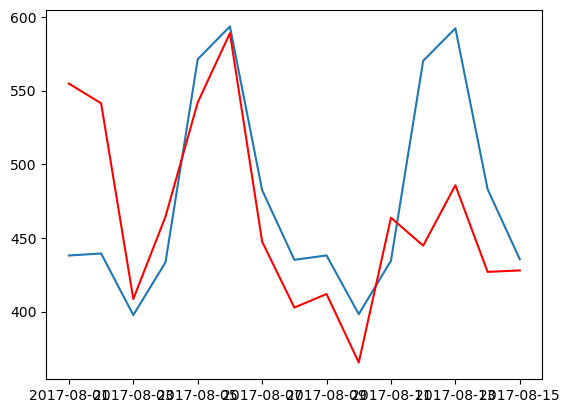

In [72]:
pyplot.plot(SARIMA_pred)
pyplot.plot(X_test, color='red')

In [64]:
# Evaluate our models
mse = mean_squared_error(X_test, SARIMA_pred)
msle = mean_squared_log_error(X_test, SARIMA_pred)
rmse = np.sqrt(mean_squared_error(X_test, SARIMA_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(X_test, SARIMA_pred)).round(2)

model_results = pd.DataFrame([['SARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,230030.436642,479.61,NaN,NaN
1,AR,2989.986841,54.68,0.013027,0.11414
2,ARIMA,4950.736069,70.36,0.020324,0.14000
3,SARIMA,4072.412620,63.82,0.016668,0.13000


## Backtest for Classical Models

In [65]:
backtests = {
    1: ('2017-07-01', '2017-07-15'),
    2: ('2017-07-15', '2017-07-30'),
    3: ('2017-08-01', '2017-08-15')
}

In [66]:
# Backtests with AR Model
scores = {}

for idx, period in enumerate(backtests):
    
    xv = train1.reset_index()[train1.reset_index()['date'] < backtests[period][0]]
    x=xv.sales.values
    _train = train1.reset_index()[train1.reset_index()['date'] < backtests[period][0]]
    _test = train1.reset_index()[(train1.reset_index()['date'] >= backtests[period][0]) & (train1.reset_index()['date'] <= backtests[period][1])]
    
    Xtrain = _train.sales.values
    Xtest = _test.sales.values
    
    model = AutoReg(x, lags = 9).fit()
    ypred = model.predict(
    start=len(_train),
    end=len(_train)+len(_test)-1,
    dynamic=False
    )
    
    scores[period] = np.sqrt(mean_squared_log_error(Xtest, ypred))

print(scores)

{1: 0.1387379433402463, 2: 0.09690180336427012, 3: 0.11413615974869984}


In [67]:
eval1=x[1658:]

In [68]:
len(eval1), len(x)

(15, 1673)

In [69]:
pred = armodel.predict(
    start=len(x)-len(eval1),
    end=len(x)-1,
    dynamic=False
)
pred[np.isnan(pred)] = 0
pred

date
2017-07-17    474.308343
2017-07-18    412.468765
2017-07-19    417.333988
2017-07-20    383.641525
2017-07-21    428.487445
2017-07-22    532.953331
2017-07-23    562.719185
2017-07-24    460.934773
2017-07-25    409.035204
2017-07-26    419.053773
2017-07-27    395.931681
2017-07-28    416.943116
2017-07-29    522.116799
2017-07-30    565.256132
2017-07-31    499.328401
Freq: D, dtype: float64

In [70]:
print(np.sqrt(mean_squared_log_error(eval1, pred)))

0.054673938589258377
